In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets,tree
from sklearn.tree import export_graphviz 
from sklearn import externals
from io import StringIO
import pydotplus
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

## Data collection and description 

In [3]:
df = pd.read_csv("Company_Data (1).csv")

In [4]:
df1 = df.copy()

In [5]:
df1.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No

In [6]:
df1.describe().T

count        mean         std   min     25%     50%     75%  \
Sales        400.0    7.496325    2.824115   0.0    5.39    7.49    9.32   
CompPrice    400.0  124.975000   15.334512  77.0  115.00  125.00  135.00   
Income       400.0   68.657500   27.986037  21.0   42.75   69.00   91.00   
Advertising  400.0    6.635000    6.650364   0.0    0.00    5.00   12.00   
Population   400.0  264.840000  147.376436  10.0  139.00  272.00  398.50   
Price        400.0  115.795000   23.676664  24.0  100.00  117.00  131.00   
Age          400.0   53.322500   16.200297  25.0   39.75   54.50   66.00   
Education    400.0   13.900000    2.620528  10.0   12.00   14.00   16.00   

                max  
Sales         16.27  
CompPrice    175.00  
Income       120.00  
Advertising   29.00  
Population   509.00  
Price        191.00  
Age           80.00  
Education     18.00

In [7]:
df1.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [8]:
df1.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

### Outlier Check

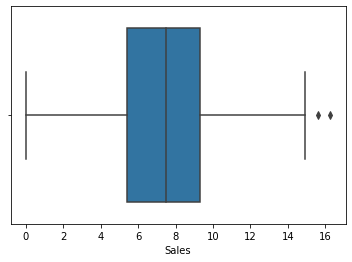

In [9]:
ax = sns.boxplot(df1['Sales'])

### The data has 2 outlier instances

In [10]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 0.18556036318721578
Kurtosis: -0.08087736743346197


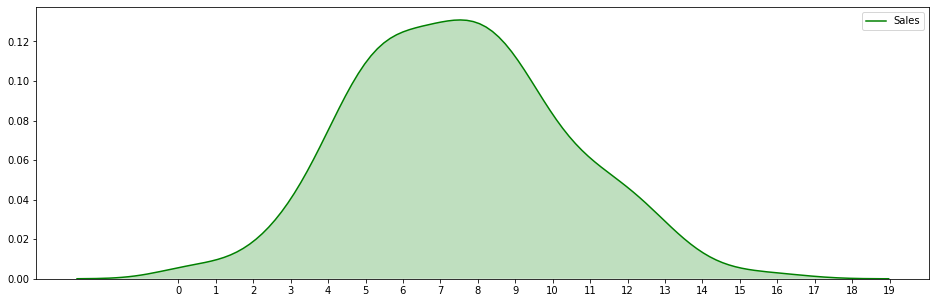

In [11]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['Sales'].skew()))
print("Kurtosis: {}".format(df1['Sales'].kurtosis()))
ax = sns.kdeplot(df1['Sales'],shade=True,color='g')
plt.xticks([i for i in range(0,20,1)])
plt.show()

### The data is Skwed on the right  
### The data has negative Kurtosis

In [12]:
obj_colum = df1.select_dtypes(include='object').columns.tolist()

C:\Users\SohailShaikh\Anaconda3\envs\Tiqets\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\SohailShaikh\Anaconda3\envs\Tiqets\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


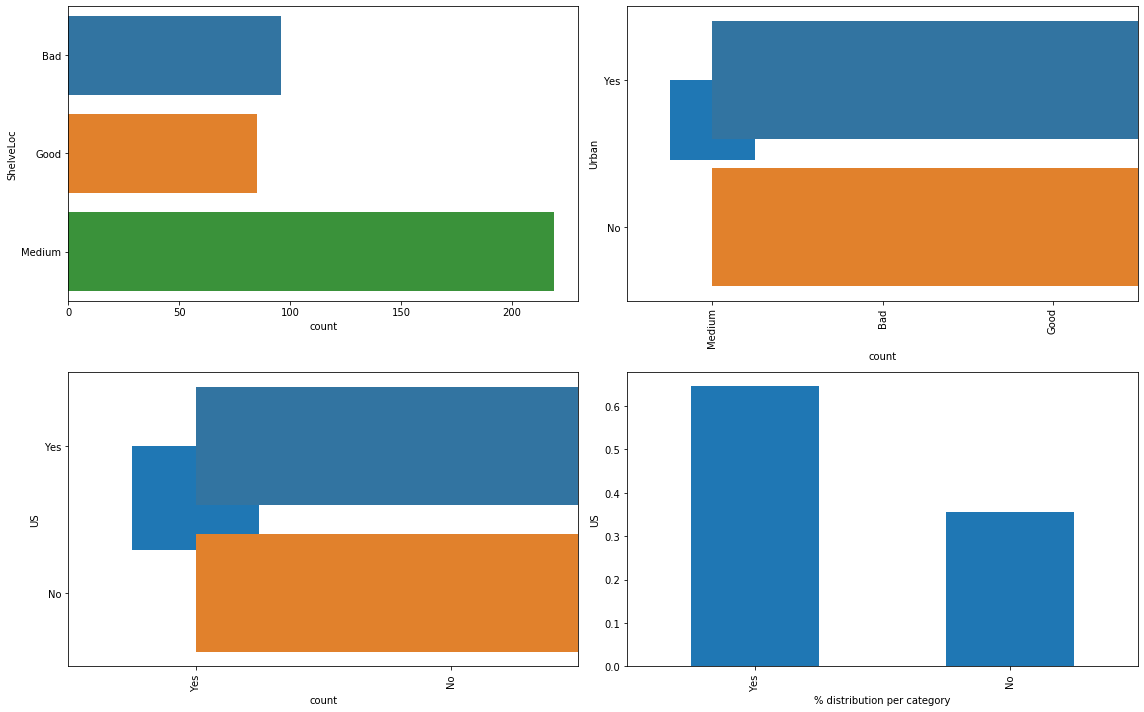

In [13]:
plt.figure(figsize=(16,10))
for i,col in enumerate(obj_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=df1,y=col)
    plt.subplot(2,2,i+1)
    df1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()  

In [14]:
num_columns = df1.select_dtypes(exclude='object').columns.tolist()

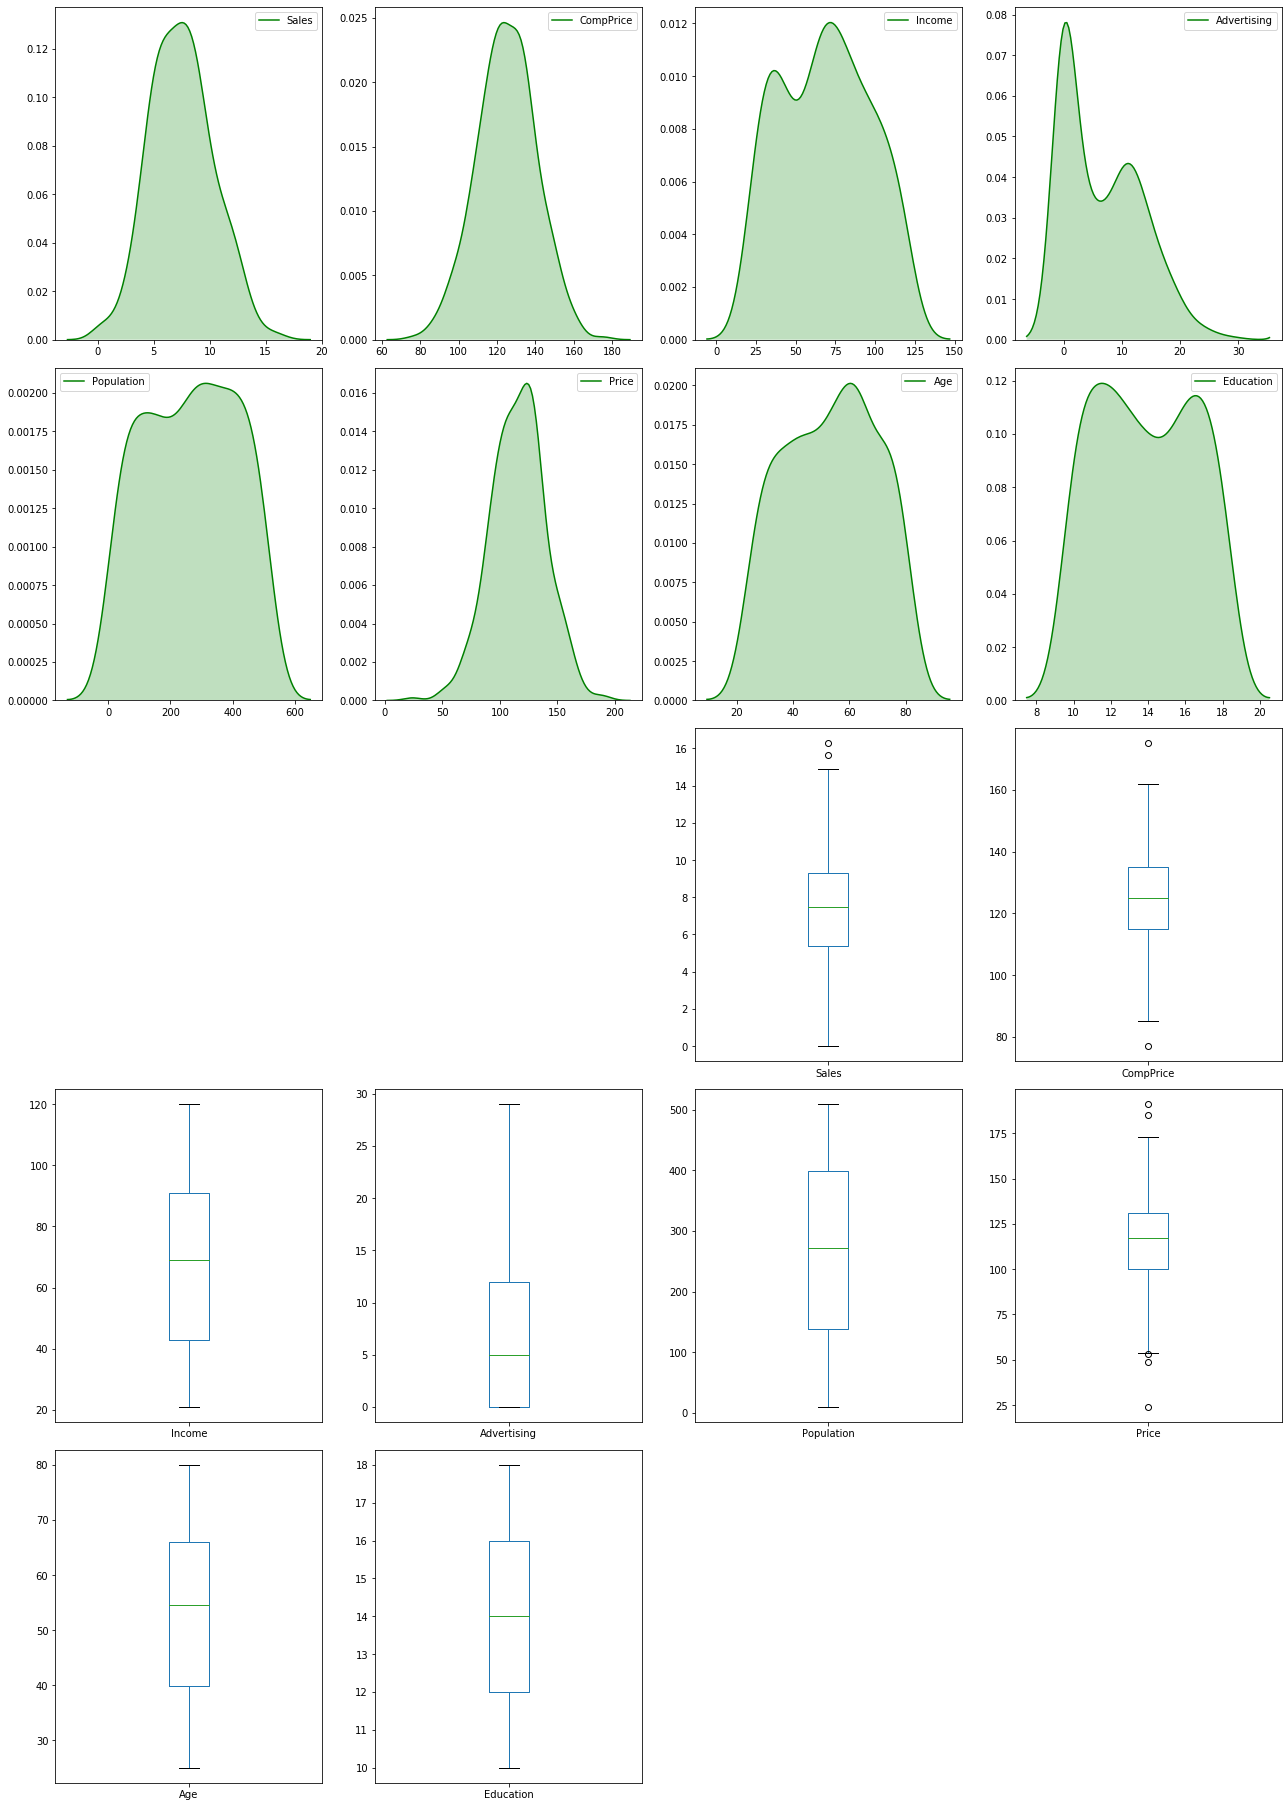

Sales  CompPrice    Income  Advertising  Population     Price  \
skewness  0.185560  -0.042755  0.049444     0.639586   -0.051227 -0.125286   
kurtosis -0.080877   0.041666 -1.085289    -0.545118   -1.202318  0.451885   

               Age  Education  
skewness -0.077182   0.044007  
kurtosis -1.134392  -1.298332

In [15]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [16]:
corr = df1.corr()

In [17]:
df1 = pd.get_dummies(df1, columns = ['ShelveLoc','Urban','US'])

In [18]:
corr = df1.corr()

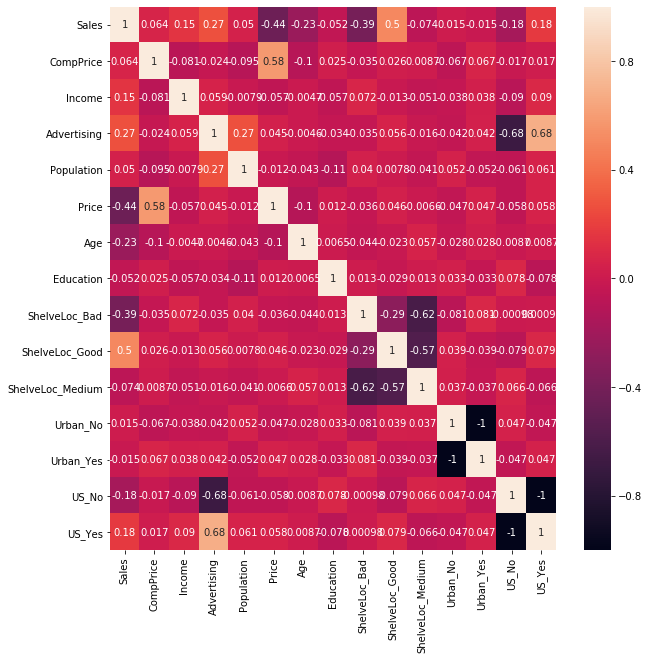

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

##  Random Forest Model 

### Since the target variable is continious, we create a class of the value based on the mean  
### <= 7.49 == "Small" and > 7.49 == "large"

In [20]:
df1["sales"]="small"
df1.loc[df1["Sales"]>7.49,"sales"]="large"
df1.drop(["Sales"],axis=1,inplace=True)

In [21]:
X = df1.iloc[:,0:14]
y = df1.iloc[:,14]

In [22]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [23]:
y_train.value_counts()

large    163
small    157
Name: sales, dtype: int64

In [24]:
model =RF(n_jobs=4,n_estimators = 150, oob_score =True,criterion ='entropy') 
model.fit(x_train,y_train)
model.oob_score_

0.809375

In [25]:
pred_train = model.predict(x_train)

In [26]:
accuracy_score(y_train,pred_train)

1.0

In [27]:
confusion_matrix(y_train,pred_train)

array([[163,   0],
       [  0, 157]], dtype=int64)

In [28]:
pred_test = model.predict(x_test)

In [29]:
accuracy_score(y_test,pred_test)

0.7625

In [30]:
confusion_matrix(y_test,pred_test)

array([[28,  8],
       [11, 33]], dtype=int64)

In [31]:
df_t=pd.DataFrame({'Actual':y_test, 'Predicted':pred_test})

In [32]:
df_t

Actual Predicted
244  large     large
255  large     small
32   small     large
178  large     large
280  small     small
..     ...       ...
246  small     small
278  small     large
160  small     small
111  small     small
324  small     small

[80 rows x 2 columns]

In [33]:
cols = list(df1.columns)

In [34]:
predictors = cols[0:14]
target = cols[14]

In [35]:
tree1 = model.estimators_[20]

In [36]:
dot_data = StringIO()

In [37]:
export_graphviz(tree1, out_file = dot_data, feature_names =predictors, class_names = target, filled =True,rounded=True,impurity =False,proportion=False,precision =2)

In [38]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [39]:
graph.write_png('company_full.png')

True

##  Conclusion 

### Since the accuracy of the Training set is 100% we test the accurancy on the test data which is 76%  
### As seen in the confusion matrix of Test data 61 instances are presdected correctly and 19 instances are not

In [40]:
rf_small = RF(n_estimators=10, max_depth = 3)

In [41]:
rf_small.fit(x_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [42]:
tree_small = rf_small.estimators_[5]

In [43]:
export_graphviz(tree_small, out_file = dot_data, feature_names = predictors, rounded = True, precision = 1)

In [44]:
graph_small = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [45]:
graph.write_png('company_small.png')

True

In [46]:
img = mpimg.imread('C:/Users/SohailShaikh/OneDrive - tiqets.com/Tiqets/Adhoc/DS/Random Forest/company_small.png') 

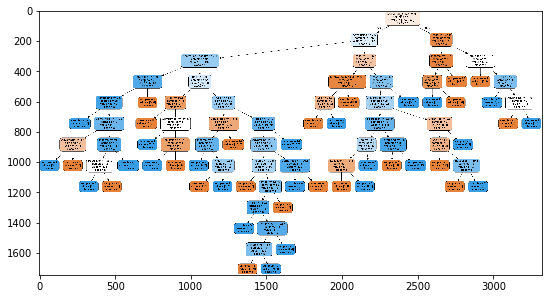

In [47]:
plt.imshow(img)

In [48]:
model.feature_importances_

array([0.11481678, 0.09928812, 0.10579556, 0.08747236, 0.2226934 ,
       0.12623161, 0.05881969, 0.04505241, 0.06932092, 0.02121305,
       0.01146601, 0.01089413, 0.01236941, 0.01456655])

In [49]:
fi = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [50]:
fi

feature  importance
4              Price    0.222693
5                Age    0.126232
0          CompPrice    0.114817
2        Advertising    0.105796
1             Income    0.099288
3         Population    0.087472
8     ShelveLoc_Good    0.069321
6          Education    0.058820
7      ShelveLoc_Bad    0.045052
9   ShelveLoc_Medium    0.021213
13            US_Yes    0.014567
12             US_No    0.012369
10          Urban_No    0.011466
11         Urban_Yes    0.010894

### As seen in the above table Price is most important feature